In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time
import numpy as np

In [2]:
print(f"TensorFlow version {tf.__version__}")

device_name = tf.test.gpu_device_name()
if not device_name:
  print('GPU device not found')
else:
  !nvidia-smi

TensorFlow version 2.7.0
GPU device not found


In [3]:
!pip install tfa-nightly

     |████████████████████████████████| 1.1 MB 9.0 MB/s 


In [4]:
import tensorflow_addons as tfa

In [5]:
!unzip -q car

# TPS Augmentation

In [6]:
# <DataUtils>

In [7]:
#! import tensorflow as tf
import tensorflow_addons as tfa

In [8]:
def get_L_inverse(X, Y):
  N = X.shape[0]
  Xmat = tf.repeat(X, repeats=[13], axis=1) # Expand to right from 13x1 to 13x13
  Ymat = tf.repeat(Y, repeats=[13], axis=1) # Expand to right from 13x1 to 13x13

  P_dist_squared = tf.square(Xmat - tf.transpose(Xmat)) + tf.square(Ymat - tf.transpose(Ymat))
  P_dist_squared = tf.where(tf.equal(P_dist_squared, 0), tf.ones_like(P_dist_squared), P_dist_squared) # remove 0 values
  K = P_dist_squared * tf.math.log(P_dist_squared)

  O = tf.ones([N, 1], dtype=tf.float32) 
  Z = tf.zeros([3, 3], dtype=tf.float32) # upper case o in equation (O)
  P = tf.concat([O, X, Y], axis=1)
  L = tf.concat([tf.concat([K, P], axis=1), tf.concat([tf.transpose(P), Z], axis=1)], axis=0)

  Li = tf.linalg.inv(L)

  return Li

In [106]:
def create_tps(height=256, width=512):
  grid_size = 3
  axis_coords_x = tf.linspace(0, height * 2, grid_size)
  # when default params: ([  0., 256., 512.]), shape 3
  axis_coords_x = tf.cast(axis_coords_x, tf.float32)

  axis_coords_y = tf.linspace(0, width * 2, grid_size)
  # when default params: ([   0.,  512., 1024.]), shape 3
  axis_coords_y = tf.cast(axis_coords_y, tf.float32)
  
  N = 13
  P_Y, P_X = tf.meshgrid(axis_coords_x, axis_coords_y) # control points
  # Each shape (grid_size, grid_size)

  # when default P_X is
  # [[  0., 256., 512.],
  # [  0., 256., 512.],
  # [  0., 256., 512.]])

  # when default P_Y is
  # [[   0.,    0.,    0.],
  # [ 512.,  512.,  512.],
  # [1024., 1024., 1024.]]
  
  P_X = tf.reshape(P_X, (-1, 1)) # shape (grid_size * grid_size, 1)
  P_Y = tf.reshape(P_Y, (-1, 1)) # shape (grid_size * grid_size, 1)

  scale = (width * 2) * 0.1
  random_points_x = tf.random.uniform(P_X.shape, minval=-scale, maxval=scale)
  random_points_y = tf.random.uniform(P_Y.shape, minval=-scale, maxval=scale)

  DST_X = P_X + random_points_x
  DST_Y = P_Y + random_points_y

  # corners of the grid 0, width * 2  0, height * 2
  corner_points_x = tf.expand_dims([0, 0, width * 2, width * 2], axis=1)
  corner_points_x = tf.cast(corner_points_x, tf.float32)

  corner_points_y = tf.expand_dims([0, height * 2, 0, height * 2], axis=1)
  corner_points_y = tf.cast(corner_points_y, tf.float32)

  DST_X = tf.concat([DST_X, corner_points_x], axis=0) # shape ((grid_size * grid_size) + 3, 1) or (N, 1)
  DST_Y = tf.concat([DST_Y, corner_points_y], axis=0) # shape ((grid_size * grid_size) + 3, 1) or (N, 1)

  Q_X = DST_X
  Q_Y = DST_Y

  Q_X = tf.cast(Q_X, tf.float32) # shape (13, 1)
  Q_Y = tf.cast(Q_Y, tf.float32) # shape (13, 1)
  # contains the modified grid, grid + random points and corner points

  P_X = tf.concat([P_X, corner_points_x], axis=0) # shape (13, 1)
  P_Y = tf.concat([P_Y, corner_points_y], axis=0) # shape (13, 1)
  # contains the original grid and corner points

  Li = get_L_inverse(Q_X, Q_Y)  # shape (16, 16)

  P_X = tf.expand_dims(P_X, 0) # shape (1, 13, 1)
  P_Y = tf.expand_dims(P_Y, 0) # shape (1, 13, 1)

  Li = tf.expand_dims(Li, 0) # shape (1, 16, 16)

  W_X = tf.linalg.matmul(Li[:, :N, :N], P_X) # Automatic broadcast for Li
  W_Y = tf.linalg.matmul(Li[:, :N, :N], P_Y) # Automatic broadcast for Li
  # 1, 13, 13 * 1, 13, 1
  # Ignoring first dimension 13, 13 * 13, 1 == 13, 1
  # shape (1, 13, 1)

  W_X = tf.expand_dims(W_X, 3)
  W_X = tf.expand_dims(W_X, 4)
  # shape (1, 13, 1, 1, 1)
  W_X = tf.transpose(W_X, [0, 4, 2, 3, 1])
  # shape (1, 1, 1, 1, 13)

  W_Y = tf.expand_dims(W_Y, 3)
  W_Y = tf.expand_dims(W_Y, 4)
  # shape (1, 13, 1, 1, 1)
  W_Y = tf.transpose(W_Y, [0, 4, 2, 3, 1])
  # shape (1, 1, 1, 1, 13)

  # compute weights for affine part
  A_X = tf.linalg.matmul(Li[:, N:, :N], P_X) # Automatic broadcast for Li
  A_Y = tf.linalg.matmul(Li[:, N:, :N], P_Y) # Automatic broadcast for Li
  # 1, 3, 13 * 1, 13, 1
  # Ignoring first dimension 3, 13 * 13, 1 == 3, 1
  # shape (1, 3, 1)

  A_X = tf.expand_dims(A_X, 3)
  A_X = tf.expand_dims(A_X, 4)
  A_X = tf.transpose(A_X, [0, 4, 2, 3, 1])

  A_Y = tf.expand_dims(A_Y, 3)
  A_Y = tf.expand_dims(A_Y, 4)
  A_Y = tf.transpose(A_Y, [0, 4, 2, 3, 1])
  # shape (1, 1, 1, 1, 3)

  grid_Y, grid_X = tf.meshgrid(tf.linspace(0, width * 2, width), tf.linspace(0, height * 2, height)) # 0, 256, 512
  # shape (256, 512)
 
  grid_X = tf.expand_dims(tf.expand_dims(grid_X, 0), 3)
  grid_Y = tf.expand_dims(tf.expand_dims(grid_Y, 0), 3)
  # shape (1, 256, 512, 1)

  points = tf.concat([grid_X, grid_Y], axis=3)
  points = tf.cast(points, tf.float32)
  # shape (1, 256, 512, 2)

  points_X_for_summation = tf.expand_dims(points[:, :, :, 0], axis=-1) # shape (1, 256, 512, 1)
  points_Y_for_summation = tf.expand_dims(points[:, :, :, 1], axis=-1)

  # change to Q
  Q_X = tf.expand_dims(Q_X, 2)
  Q_X = tf.expand_dims(Q_X, 3)
  Q_X = tf.expand_dims(Q_X, 4)
  Q_X = tf.transpose(Q_X) # shape (1, 1, 1, 1, 13)

  Q_Y = tf.expand_dims(Q_Y, 2)
  Q_Y = tf.expand_dims(Q_Y, 3)
  Q_Y = tf.expand_dims(Q_Y, 4)
  Q_Y = tf.transpose(Q_Y) # shape (1, 1, 1, 1, 13)

  delta_X = Q_X - tf.expand_dims(points_X_for_summation, axis=-1)
  delta_Y = Q_Y - tf.expand_dims(points_Y_for_summation, axis=-1)
  # shape 1, 256, 512, 1, 13

  dist_squared = tf.square(delta_X) + tf.square(delta_Y)
  dist_squared = tf.where(tf.equal(dist_squared, 0), tf.ones_like(dist_squared), dist_squared) # remove 0 values
  U = dist_squared * tf.math.log(dist_squared)
  # shape 1, 256, 512, 1, 13

  points_X_prime = A_X[:, :, :, :, 0] + (A_X[:, :, :, :, 1] * points_X_for_summation) + (A_X[:, :, :, :, 2] * points_Y_for_summation)
  points_X_prime += tf.keras.backend.sum((W_X * U), axis=-1)

  points_Y_prime = A_Y[:, :, :, :, 0] + (A_Y[:, :, :, :, 1] * points_X_for_summation) + (A_Y[:, :, :, :, 2] * points_Y_for_summation)
  points_Y_prime += tf.keras.backend.sum((W_Y * U), axis=-1)
  # shape (1, 256, 512, 1)

  warped_grid = tf.concat([points_X_prime, points_Y_prime], axis=-1)
  # shape (1, 256, 512, 2)

  return warped_grid

In [37]:
def tps_augmentation(img, tps, height=256, width=512):
  new_max = width
  new_min = 0
  grid_x = (new_max - new_min) / (tf.keras.backend.max(tps[:, :, :, 1]) - tf.keras.backend.min(tps[:, :, :, 1])) * (tps[:, :, :, 1] - tf.keras.backend.max(tps[:, :, :, 1])) + new_max

  new_max = height
  new_min = 0
  grid_y = (new_max - new_min) / (tf.keras.backend.max(tps[:, :, :, 0]) - tf.keras.backend.min(tps[:, :, :, 0])) * (tps[:, :, :, 0] - tf.keras.backend.max(tps[:, :, :, 0])) + new_max

  grid = tf.stack([grid_x, grid_y], axis=-1)

  final_image = tfa.image.resampler(tf.expand_dims(img, axis=0), grid)
  
  return final_image[0]

In [ ]:
# <DataUtilsEnd>

In [93]:
tps = create_tps(height=256, width=512)
# use grid_Y, grid_X = tf.meshgrid(tf.linspace(0, 512 * 2, 32), tf.linspace(0, 512 * 2, 32)) # 0, 256, 512

In [76]:
grid_Y, grid_X = tf.meshgrid(tf.linspace(0, 512 * 2, 32), tf.linspace(0, 512 * 2, 32)) # 0, 256, 512

In [77]:
grid_xx = tf.reshape(grid_X, -1)
grid_yy = tf.reshape(grid_Y, -1)

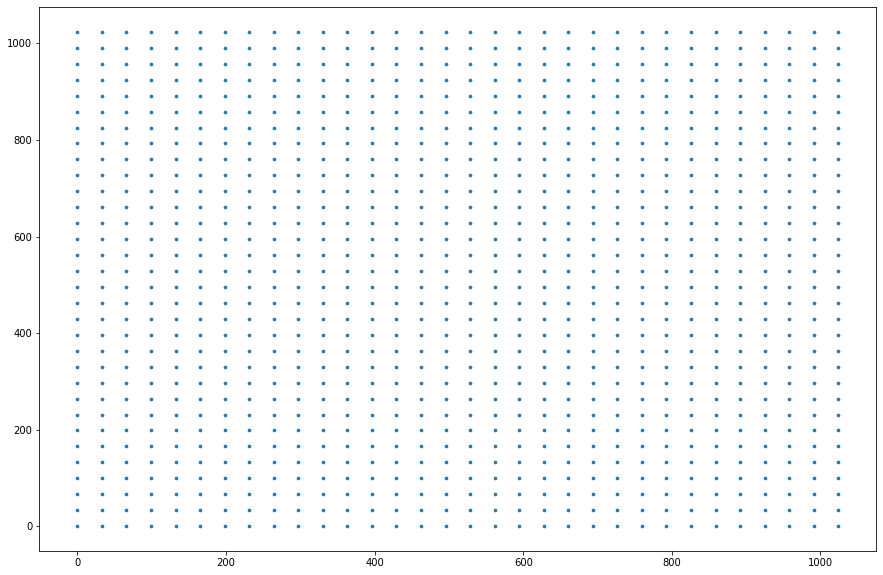

In [86]:
plt.subplots(figsize=(15, 10))
plt.scatter(grid_xx, grid_yy, s=7)

In [94]:
tps_x = tf.reshape(tps[0, :, :, 0], -1)
tps_y = tf.reshape(tps[0, :, :, 1], -1)

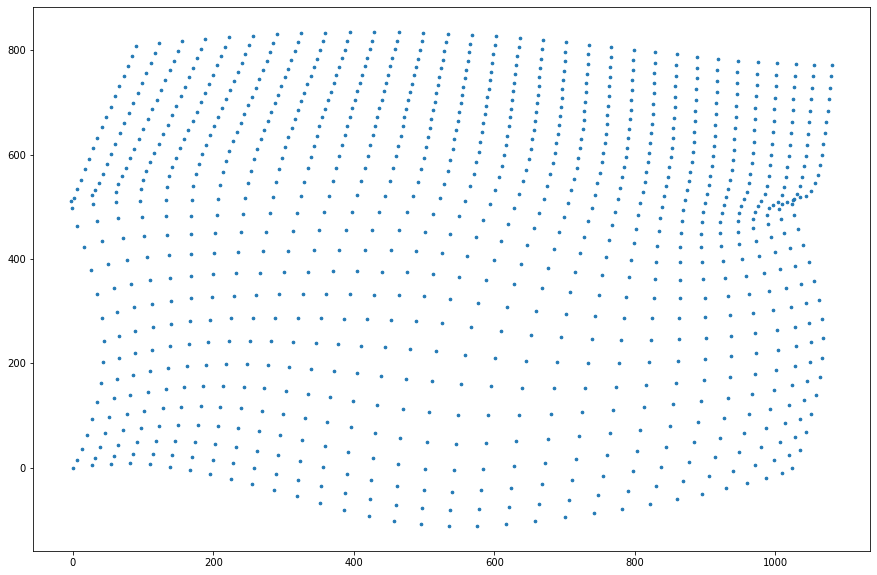

In [85]:
plt.subplots(figsize=(15, 10))
plt.scatter(tps_x, tps_y, s=7)

# Data Generator

In [ ]:
# <DataGenerator>

In [ ]:
#! import tensorflow as tf
#! import os
#! from data_generator.data_utils import create_tps, tps_augmentation

In [113]:
data_path = os.path.abspath("./data/car")

In [99]:
image_height = 256
image_width = 512

In [100]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [image_height, image_width])
  
  return img

In [101]:
def augment_image(img, flip, tps):
  img = tps_augmentation(img, tps)

  if flip:
    img = tf.image.flip_left_right(img)
  
  return img

In [102]:
def load_train_image(data_path):
  input_img = load_image(tf.strings.join([data_path, "/input/", "car.png"])) # load the image in range (0, 1)
  label_img = load_image(tf.strings.join([data_path, "/real/", "car.png"])) # load the image in range (0, 1)

  flip = tf.random.uniform([]) > 0.5

  tps = create_tps()

  input_img = augment_image(input_img, flip, tps)
  label_img = augment_image(label_img, flip, tps)

  return input_img, label_img

In [109]:
train_dataset = tf.data.Dataset.from_tensor_slices([data_path])
train_dataset = train_dataset.map(load_train_image)

In [ ]:
# <DataGeneratorEnd>

# Data Generator Test

In [ ]:
# <DataGeneratorTest>

In [ ]:
#! import tensorflow as tf
#! import numpy as np
#! import matplotlib.pyplot as plt
#! from data_generator.data_generator import train_dataset 

In [110]:
train_generator = train_dataset.batch(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 512, 3)


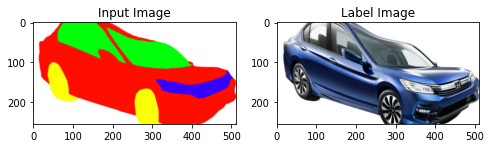

In [111]:
for input_img, label_img in train_generator:
  print(input_img.shape)
  _, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 10))
  ax[0].set_title("Input Image")
  ax[0].imshow(input_img[0])

  ax[1].set_title("Label Image")
  ax[1].imshow(label_img[0])

In [ ]:
input_img.numpy().min(), input_img.numpy().max()

(0.0, 1.0000001)

In [ ]:
label_img.numpy().min(), label_img.numpy().max()

(0.0, 1.0000001)

In [ ]:
# <DataGeneratorTestEnd>

# Blocks

In [ ]:
# <Blocks>

In [ ]:
#! import tensorflow as tf
#! from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
class ResBlock(tf.keras.Model):
  def __init__(self):
    super(ResBlock, self).__init__()
    self.conv_1 = layers.Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding='valid', kernel_initializer=kernel_init)
    self.conv_2 = layers.Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding='valid', kernel_initializer=kernel_init)

    self.norm_1 = tfa.layers.InstanceNormalization()
    self.norm_2 = tfa.layers.InstanceNormalization()

    self.padding_values = [[0, 0], [1, 1], [1, 1], [0, 0]]
  
  def call(self, x):
    x_skip = x 

    x = tf.pad(x, self.padding_values, mode="REFLECT")

    x = self.conv_1(x)
    x = self.norm_1(x)
    x = layers.ReLU()(x)

    x = tf.pad(x, self.padding_values, mode="REFLECT")
    
    x = self.conv_2(x)
    x = self.norm_2(x)

    x = layers.add([x, x_skip])

    return x

In [ ]:
# <BlocksEnd>

# Models

In [ ]:
# <Model>

In [ ]:
#! import tensorflow as tf
#! from tensorflow.keras import layers
#! from networks.model_blocks import ResBlock
import tensorflow_addons as tfa

In [ ]:
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()

    self.conv_1 = layers.Conv2D(64, kernel_size=(7, 7), strides=(1, 1), padding='valid', kernel_initializer=kernel_init)
    self.conv_2 = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_3 = layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_4 = layers.Conv2D(512, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_5 = layers.Conv2D(1024, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=kernel_init)


    self.norm_1 = tfa.layers.InstanceNormalization()
    self.norm_2 = tfa.layers.InstanceNormalization()
    self.norm_3 = tfa.layers.InstanceNormalization()
    self.norm_4 = tfa.layers.InstanceNormalization()

    self.norm_5 = tfa.layers.InstanceNormalization()
    self.norm_6 = tfa.layers.InstanceNormalization()
    self.norm_7 = tfa.layers.InstanceNormalization()
    self.norm_8 = tfa.layers.InstanceNormalization()
    self.norm_9 = tfa.layers.InstanceNormalization()

    self.res_block_1 = ResBlock()
    self.res_block_2 = ResBlock()
    self.res_block_3 = ResBlock()
    self.res_block_4 = ResBlock()
    self.res_block_5 = ResBlock()
    self.res_block_6 = ResBlock()
    self.res_block_7 = ResBlock()
    self.res_block_8 = ResBlock()
    self.res_block_9 = ResBlock()

    # Transpose, change to upsampling after!

    self.conv_6 = layers.Conv2DTranspose(512, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)
    self.conv_7 = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)
    self.conv_8 = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)
    self.conv_9 = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)
    self.conv_10 = layers.Conv2D(3, kernel_size=(7, 7), strides=(1, 1), padding='valid', kernel_initializer=kernel_init)

    self.padding_values = [[0, 0], [3, 3], [3, 3], [0, 0]]


  def call(self, x):
    # inputs 640x640x3
    # example used 256, 256, 3

    x = tf.pad(x, self.padding_values, mode="REFLECT")
    x = self.conv_1(x)
    x = self.norm_1(x)
    x = layers.ReLU()(x)

    x = self.conv_2(x)
    x = self.norm_2(x)
    x = layers.ReLU()(x)

    x = self.conv_3(x)
    x = self.norm_3(x)
    x = layers.ReLU()(x)

    x = self.conv_4(x)
    x = self.norm_4(x)
    x = layers.ReLU()(x)

    x = self.conv_5(x)
    x = self.norm_5(x)
    x = layers.ReLU()(x)

    x = self.res_block_1(x)
    x = self.res_block_2(x)
    x = self.res_block_3(x)
    x = self.res_block_4(x)
    x = self.res_block_5(x)
    x = self.res_block_6(x)
    x = self.res_block_7(x)
    x = self.res_block_8(x)
    x = self.res_block_9(x)

    x = self.conv_6(x)
    x = self.norm_6(x)
    x = layers.ReLU()(x)

    x = self.conv_7(x)
    x = self.norm_7(x)
    x = layers.ReLU()(x)

    x = self.conv_8(x)
    x = self.norm_8(x)
    x = layers.ReLU()(x)

    x = self.conv_9(x)
    x = self.norm_9(x)
    x = layers.ReLU()(x)

    x = tf.pad(x, self.padding_values, mode="REFLECT")
    x = self.conv_10(x)
    x = tf.keras.activations.tanh(x)

    return x

In [ ]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv_1 = layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_2 = layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_3 = layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_4 = layers.Conv2D(512, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=kernel_init)

    self.conv_5 = layers.Conv2D(1, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=kernel_init)

    self.conv_6 = layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_7 = layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_8 = layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_init)
    self.conv_9 = layers.Conv2D(512, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=kernel_init)

    self.conv_10 = layers.Conv2D(1, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=kernel_init)

    self.norm_1 = tfa.layers.InstanceNormalization()
    self.norm_2 = tfa.layers.InstanceNormalization()
    self.norm_3 = tfa.layers.InstanceNormalization()
  
    self.norm_4 = tfa.layers.InstanceNormalization()
    self.norm_5 = tfa.layers.InstanceNormalization()
    self.norm_6 = tfa.layers.InstanceNormalization()
    
  def call(self, input_tensor):
    # input size HxwX6 channels=6
    output_1 = []
    output_2 = []
    
    x = input_tensor
    x = self.conv_1(x)
    x = layers.LeakyReLU()(x)

    output_1.append(x)

    x = self.conv_2(x)
    x = self.norm_1(x)
    x = layers.LeakyReLU()(x)

    output_1.append(x)

    x = self.conv_3(x)
    x = self.norm_2(x)
    x = layers.LeakyReLU()(x)

    output_1.append(x)

    x = self.conv_4(x)
    x = self.norm_3(x)
    x = layers.LeakyReLU()(x)

    output_1.append(x)

    x = self.conv_5(x)

    output_1.append(x)

    x2 = layers.AveragePooling2D()(input_tensor)
    x2 = self.conv_6(x2)
    x2 = layers.LeakyReLU()(x2)

    output_2.append(x2)

    x2 = self.conv_7(x2)
    x2 = self.norm_4(x2)
    x2 = layers.LeakyReLU()(x2)

    output_2.append(x2)

    x2 = self.conv_8(x2)
    x2 = self.norm_5(x2)
    x2 = layers.LeakyReLU()(x2)

    output_2.append(x2)

    x2 = self.conv_9(x2)
    x2 = self.norm_6(x2)
    x2 = layers.LeakyReLU()(x2)

    output_2.append(x2)

    x2 = self.conv_10(x2)

    output_2.append(x2)

    return [output_1, output_2]

### VGG

In [ ]:
class Vgg19(tf.keras.Model):
  def __init__(self):
    super(Vgg19, self).__init__()
    layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layers]

    self.model = tf.keras.Model([vgg.input], outputs)
  
  def call(self, x):
    x = tf.keras.applications.vgg19.preprocess_input(x * 255.0)
    return self.model(x)

In [ ]:
# <ModelEnd>

# Loss Functions

In [ ]:
# <Loss>

In [ ]:
#! import tensorflow as tf

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
def discriminator_fake_loss(input_features):
  loss = 0.0

  for input_i in input_features: # list of 2
    pred = input_i[-1] # list of 5 where we take the last element
    loss += mse(tf.zeros_like(pred), pred)

  return loss

In [ ]:
def discriminator_real_loss(input_features):
  loss = 0.0

  for input_i in input_features: # list of 2
    pred = input_i[-1] # list of 5 where we take the last element
    loss += mse(tf.ones_like(pred), pred)

  return loss

In [ ]:
def compute_discriminator_loss(real_features, fake_features):
  loss = discriminator_fake_loss(fake_features) + discriminator_real_loss(real_features) * 0.5

  return loss

In [ ]:
def feature_matching_loss(real_features, fake_features):
  D_weights = 1.0 / 2.0
  feat_weights = 4.0 / (3 + 1)
  lambda_feat = 10.0

  loss = 0.0
  
  for i in range(2):
    for j in range(len(fake_features[i]) - 1): # 5-1
      loss += D_weights * feat_weights * tf.reduce_mean(tf.abs(real_features[i][j] - fake_features[i][j])) * lambda_feat

  return loss

In [ ]:
def perceptual_loss(true_list, fake_list):
  lambda_feat = 10.0
  weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]        

  loss = 0
  for feature_map_y, feature_map, w in zip(true_list, fake_list, weights):
    loss += w * tf.reduce_mean(tf.abs(feature_map_y - feature_map))
  
  return loss

In [ ]:
def compute_generator_loss(real_features, fake_features, true_list, fake_list):
  loss = discriminator_real_loss(fake_features)
  loss += feature_matching_loss(real_features, fake_features)

  loss += perceptual_loss(true_list, fake_list)

  return loss

In [ ]:
# <LossEnd>

# Training Utils

In [ ]:
# <TrainingUtils>

In [ ]:
#! import tensorflow as tf

#! from networks.loss_functions import compute_generator_loss, compute_discriminator_loss

In [ ]:
def inner_step(input_img,
               label_img,
               discriminator,
               generator,
               vgg,
               generator_optimizer,
               discriminator_optimizer
               ):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_image = generator(input_img)

    discriminator_fake_input = tf.concat([input_img, fake_image], axis=-1)
    fake_prediction = discriminator(discriminator_fake_input)

    discriminator_real_input = tf.concat([input_img, label_img], axis=-1)
    real_prediction = discriminator(discriminator_real_input)

    true_list = vgg(label_img)
    fake_list = vgg(fake_image)

    generator_loss = compute_generator_loss(real_prediction, fake_prediction, true_list, fake_list)
    discriminator_loss = compute_discriminator_loss(real_prediction, fake_prediction)
  
  g_gradients = gen_tape.gradient(generator_loss, generator.trainable_variables)
  d_gradients = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

  return generator_loss, discriminator_loss

In [ ]:
def lr_decay(optimizer, learning_rate):
  current_lr = optimizer.lr
  new_lr = current_lr - (learning_rate / 8000)
  optimizer.lr = new_lr

  return optimizer

In [ ]:
# <TrainingUtilsEnd>

# Model Testing

In [ ]:
# <ModelTest>

In [ ]:
#! import tensorflow as tf
#! from networks.models import Generator, Discriminator

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator_input_shape = (2, 256, 512, 3)
generator_input = tf.random.normal(generator_input_shape)

In [ ]:
generator_output = generator(generator_input)
# discriminator_output = generator(generator_output)

In [ ]:
def test_generator_output_shape():
  assert generator_output.shape == (2, 256, 512, 3), generator_output.shape

In [ ]:
# <ModelTestEnd>

# Training

In [ ]:
# <Train>

In [ ]:
#! import tensorflow as tf
#! import time
#! import os
#! from train_utils import inner_step, lr_decay
import builtins

In [ ]:
#! from networks.models import Generator, Discriminator, Vgg19
#! from data_generator.data_generator import train_dataset 

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser()

In [ ]:
parser.add_argument('--epochs', type=int, default=12000, help='Number of epochs to train the model')
parser.add_argument('--continue_training', default=False, action='store_true', help='Use training checkpoints to continue training the model')
parser.add_argument('--save_generator', default=False, action='store_true', help='Save the generator after training')

_StoreTrueAction(option_strings=['--save_generator'], dest='save_generator', nargs=0, const=True, default=False, type=None, choices=None, help='Save the generator after training', metavar=None)

In [ ]:
using_notebook = getattr(builtins, "__IPYTHON__", False)

In [ ]:
opts = parser.parse_args([]) if using_notebook else parser.parse_args()

In [ ]:
learning_rate = 0.0002
generator_lr = learning_rate
discriminator_lr = learning_rate

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_lr, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=discriminator_lr, beta_1=0.5, beta_2=0.999)

In [ ]:
batch_size = 1

In [ ]:
train_generator = train_dataset.batch(batch_size)

In [ ]:
generator = Generator()
discriminator = Discriminator()
vgg = Vgg19()

80150528/80134624 [==============================] - 0s 0us/step


### Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer)

In [ ]:
if opts.continue_training:
  print("loading training checkpoints: ")                   
  print(tf.train.latest_checkpoint(checkpoint_dir))
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Train

In [ ]:
@tf.function
def train_step(input_img, label_img):
  return inner_step(input_img,
                    label_img,
                    discriminator,
                    generator,
                    vgg,
                    generator_optimizer,
                    discriminator_optimizer)

In [ ]:
train_loss_results, train_loss_metric = [], tf.keras.metrics.Mean()
gen_loss_results, gen_loss_metric = [], tf.keras.metrics.Mean()
disc_loss_results, disc_loss_metric = [], tf.keras.metrics.Mean()

In [ ]:
epochs = opts.epochs
start_epoch = 0
epoch_decay = 8000

In [ ]:
def train(epochs):
  for epoch in range(start_epoch, epochs):
    epoch_time = time.time()
    epoch_count = f"0{epoch + 1}/{epochs}" if epoch < 9 else f"{epoch + 1}/{epochs}"

    for input_img, label_img in train_generator:
      generator_loss, discriminator_loss = train_step(input_img, label_img)

      generator_loss = float(generator_loss)
      discriminator_loss = float(discriminator_loss)
      loss = generator_loss + discriminator_loss  
        
    train_loss_results.append(loss)
    gen_loss_results.append(generator_loss)
    disc_loss_results.append(discriminator_loss)
    
    if (epoch % 250 ) == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    if epoch > epoch_decay:
      generator_optimizer = lr_decay(generator_optimizer, learning_rate)
      discriminator_optimizer = lr_decay(discriminator_optimizer, learning_rate)
    
    if (epoch % 100) == 0:
      print('\r', 'Epoch', epoch_count, '| Loss:', f"{loss:.5f}", '| Discriminator loss:', f"{discriminator_loss:.5f}",
          '| Generator loss:', f"{generator_loss:.5f}", "| Epoch Time:", f"{time.time() - epoch_time:.2f}")

In [ ]:
#! train(epochs)

In [ ]:
if opts.save_generator:
  generator.save('saved_model/tps_generator')

In [ ]:
# <TrainEnd>

In [ ]:
train(epochs)

 Epoch 01/12000 | Loss: 568.31111 | Discriminator loss: 7.90309 | Generator loss: 560.40802 | Epoch Time: 20.54
 Epoch 101/12000 | Loss: 190.92688 | Discriminator loss: 0.59890 | Generator loss: 190.32799 | Epoch Time: 0.69
 Epoch 201/12000 | Loss: 173.77620 | Discriminator loss: 0.72064 | Generator loss: 173.05556 | Epoch Time: 0.72
 Epoch 301/12000 | Loss: 138.67129 | Discriminator loss: 0.48651 | Generator loss: 138.18478 | Epoch Time: 0.70
 Epoch 401/12000 | Loss: 130.75290 | Discriminator loss: 0.40346 | Generator loss: 130.34944 | Epoch Time: 0.71
 Epoch 501/12000 | Loss: 150.67508 | Discriminator loss: 0.56835 | Generator loss: 150.10674 | Epoch Time: 0.70
 Epoch 601/12000 | Loss: 133.91800 | Discriminator loss: 0.33194 | Generator loss: 133.58606 | Epoch Time: 0.71
 Epoch 701/12000 | Loss: 124.22589 | Discriminator loss: 0.43161 | Generator loss: 123.79428 | Epoch Time: 0.70
 Epoch 801/12000 | Loss: 122.43356 | Discriminator loss: 0.47138 | Generator loss: 121.96218 | Epoch Tim

In [ ]:
train(8000)

 Epoch 01/8000 | Loss: 587.47229 | Discriminator loss: 5.95495 | Generator loss: 581.51733 | Epoch Time: 20.48
 Epoch 101/8000 | Loss: 215.83412 | Discriminator loss: 0.63040 | Generator loss: 215.20372 | Epoch Time: 0.66
 Epoch 201/8000 | Loss: 158.47328 | Discriminator loss: 0.47337 | Generator loss: 157.99991 | Epoch Time: 0.68
 Epoch 301/8000 | Loss: 113.15959 | Discriminator loss: 0.17037 | Generator loss: 112.98921 | Epoch Time: 0.68
 Epoch 401/8000 | Loss: 82.51777 | Discriminator loss: 0.57499 | Generator loss: 81.94279 | Epoch Time: 0.68
 Epoch 501/8000 | Loss: 75.86002 | Discriminator loss: 0.62162 | Generator loss: 75.23840 | Epoch Time: 0.69
 Epoch 601/8000 | Loss: 63.58978 | Discriminator loss: 0.68161 | Generator loss: 62.90818 | Epoch Time: 0.68
 Epoch 701/8000 | Loss: 60.59313 | Discriminator loss: 0.69254 | Generator loss: 59.90060 | Epoch Time: 0.69
 Epoch 801/8000 | Loss: 55.86387 | Discriminator loss: 0.49278 | Generator loss: 55.37109 | Epoch Time: 0.69
 Epoch 901/

In [ ]:
loss_metrics = {
    "loss": train_loss_results,
    "generator loss": generator_loss_results,
    "discriminator loss": discriminator_loss_results,
}

In [ ]:
def plot_metrics(loss_metrics, vertical_size, horizontal_size, figsize=(15, 15)):
  vertical_axes = list(range(vertical_size))
  horizontal_axes = list(range(horizontal_size))

  fig, ax = plt.subplots(vertical_size, horizontal_size, figsize=figsize)
  counter = 0

  metrics_names = list(loss_metrics.keys())
  count = len(metrics_names)

  if vertical_size == 1:
    for x in horizontal_axes:
      title = metrics_names[counter]
      value = loss_metrics[title]
      ax[x].plot(np.arange(len(value)), value)
      ax[x].set_title(title)
      counter += 1
  else:
    for y in vertical_axes:
      for x in horizontal_axes:
        title = metrics_names[counter]
        value = loss_metrics[title]
        ax[y, x].plot(np.arange(len(value)), value)
        ax[y, x].set_title(title)
        counter += 1

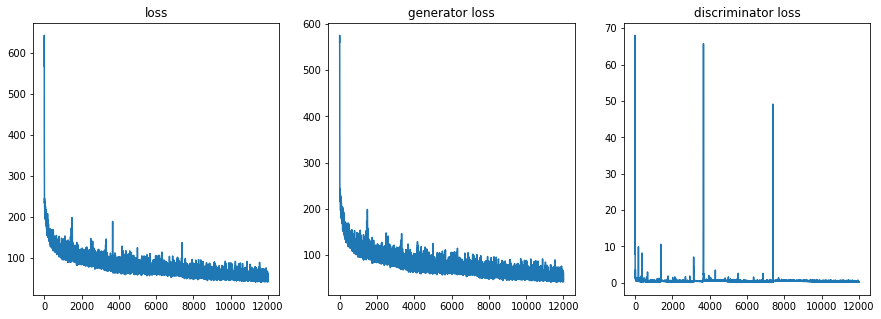

In [ ]:
plot_metrics(loss_metrics, 1, 3, figsize=(15, 5))

# Use model

In [ ]:
## !unzip -q car_test

In [ ]:
# <UseModel>

In [ ]:
#! from data_generator.data_generator import load_image
#! import tensorflow as tf
#! import os
#! import matplotlib.pyplot as plt

In [ ]:
data_path = os.path.abspath("./data/car_test")

In [ ]:
img_test_1 = load_image(f"{data_path}/car_test1.png")
img_test_2 = load_image(f"{data_path}}/car_test2.png")

In [ ]:
input = tf.stack([img_test_1, img_test_2], axis=0)

In [ ]:
#! generator = tf.keras.models.load_model('saved_model/tps_generator')

In [ ]:
results = generator(input)

In [ ]:
plt.imsave("image1.jpg", results[0])
plt.imsave("image2.jpg", results[1])

In [ ]:
# <UseModelEnd>

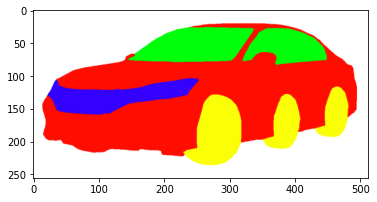

In [ ]:
plt.imshow(input[0])

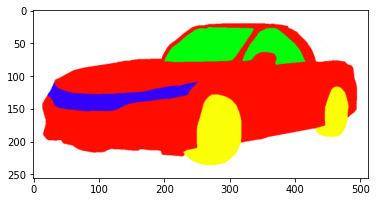

In [ ]:
plt.imshow(input[1])

In [ ]:
results.shape

TensorShape([2, 256, 512, 3])

In [ ]:
results[0].numpy().max()

0.99999994

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


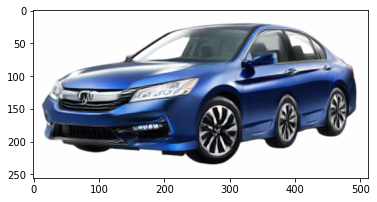

In [ ]:
plt.imshow(results[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


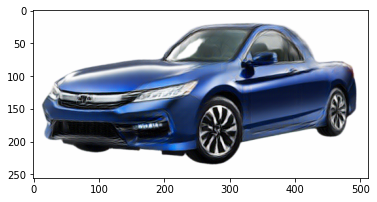

In [ ]:
plt.imshow(results[1])

In [ ]:
# <UseModelEnd>

In [ ]:
generator.save('saved_model/tps_generator_12000')

INFO:tensorflow:Assets written to: saved_model/tps_generator_12000/assets
